Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type                     | Params
---------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5     
1 | padder_train            | ConstantPad1d            | 0     
2 | scaler                  | TemporalNorm             | 0     
3 | embedding               | TFTEmbedding             | 160   
4 | static_encoder          | StaticCovariateEncoder   | 9.9 K 
5 | temporal_encoder        | TemporalCovariateEncoder | 18.1 K
6 | temporal_fusion_decoder | TemporalFusionDecoder    | 6.6 K 
7 | output_adapter          | Linear                   | 63    
---------------------------------------------------------------------
34.9 K    Trainable params
5         Non-trainable params
34.9 K    Total params
0.139     Total estimated model params si

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

/Users/ericzhang/opt/anaconda3/lib/python3.11/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[]

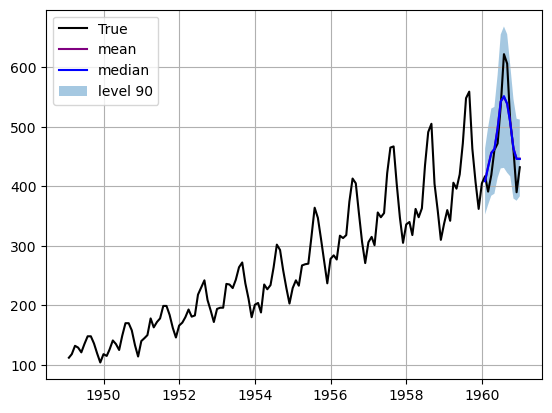

In [5]:
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

file_path = '../../SP500.csv'  # Make sure to have your dataset ready
df = pd.read_csv(file_path)
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

#AirPassengersPanel['y'] = AirPassengersPanel['y'] + 10
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[TFT(h=12, input_size=48,
                hidden_size=20,
                #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
                #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                learning_rate=0.005,
                stat_exog_list=['airline1'],
                #futr_exog_list=['y_[lag12]'],
                hist_exog_list=['trend'],
                max_steps=500,
                val_check_steps=10,
                early_stop_patience_steps=10,
                scaler_type='robust',
                windows_batch_size=None,
                enable_progress_bar=True),
    ],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
Y_hat_df = nf.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['TFT'], c='purple', label='mean')
plt.plot(plot_df['ds'], plot_df['TFT-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['TFT-lo-90'][-12:].values, 
                 y2=plot_df['TFT-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [3]:
TimeSeriesDataset

neuralforecast.tsdataset.TimeSeriesDataset

In [4]:
AirPassengers

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

In [6]:
Y_train_df

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1949-01-31,112.0,0,112.0
1,Airline1,1949-02-28,118.0,1,118.0
2,Airline1,1949-03-31,132.0,2,132.0
3,Airline1,1949-04-30,129.0,3,129.0
4,Airline1,1949-05-31,121.0,4,121.0
...,...,...,...,...,...
271,Airline2,1959-08-31,859.0,271,805.0
272,Airline2,1959-09-30,763.0,272,704.0
273,Airline2,1959-10-31,707.0,273,659.0
274,Airline2,1959-11-30,662.0,274,610.0
